In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import random
import math

import torch
from torch import nn, optim
import torch.nn.functional as F
from collections import deque

In [199]:
## hyper parameters

episodes = 200
e_start = 0.9
e_end = 0.05
e_decay = 200
e_step = 0
gamma = 0.8
lr = 0.001
batch_size = 64

In [200]:
class DQN_MountainCar(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.step = 0
        self.deque = deque(maxlen=1000)

    def memorize(self, state, action, reward, next_state):
        self.deque.append((state,
                           action,
                           torch.FloatTensor([reward]),
                           torch.FloatTensor([next_state])
                           ))
    
    def action(self, state):
        eps_theta = e_end + (e_start - e_end)*np.exp(-(self.step/e_decay))
        self.step += 1
        if np.random.rand() < eps_theta:
            return torch.LongTensor([[np.random.choice([0, 1])]])
        else:
            return self.model(state).data.argmax().view(1, 1)
        
    def learning(self):
        if len(self.deque) < batch_size*4:
            return
        batch = random.sample(self.deque, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (gamma*max_next_q)

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [196]:
def calc_reward(state):
    position = state[0][0]
    velocity = state[0][1]

    position_reward = 0.1 * (position + 1.2)
    velocity_reward = 13.0 * abs(velocity)
    reward = position_reward + velocity_reward

    return reward, position_reward, velocity_reward

In [201]:
env = gym.make('MountainCar-v0')
# env = gym.make('MountainCar-v0', render_mode='human')
agent = DQN_MountainCar()
scores = []

In [149]:
state, _ = env.reset()
state = torch.FloatTensor([state])
print(state)
action = agent.action(state)
print(action)
next_state, reward, terminated, truncated, _ = env.step(action.item())
print(reward)
reward += calc_reward(state)
print(reward)

tensor([[-0.4807,  0.0000]])
tensor([[1]])
-1.0
tensor(-1.)


Episode: 1 / episode_len: 200 / pos : 11.67 / vel : 8.09 / eps : 0.364
Episode: 2 / episode_len: 200 / pos : 12.41 / vel : 20.82 / eps : 0.166
Episode: 3 / episode_len: 200 / pos : 12.86 / vel : 15.61 / eps : 0.093
Episode: 4 / episode_len: 200 / pos : 11.68 / vel : 50.56 / eps : 0.066
Episode: 5 / episode_len: 200 / pos : 12.99 / vel : 58.58 / eps : 0.056
Episode: 6 / episode_len: 200 / pos : 12.59 / vel : 60.15 / eps : 0.052
Episode: 7 / episode_len: 200 / pos : 12.67 / vel : 66.37 / eps : 0.051
Episode: 8 / episode_len: 200 / pos : 12.70 / vel : 50.48 / eps : 0.050
Episode: 9 / episode_len: 200 / pos : 12.35 / vel : 19.81 / eps : 0.050
Episode: 10 / episode_len: 200 / pos : 12.60 / vel : 67.00 / eps : 0.050
Episode: 11 / episode_len: 200 / pos : 12.03 / vel : 56.44 / eps : 0.050
Episode: 12 / episode_len: 200 / pos : 12.08 / vel : 58.03 / eps : 0.050
Episode: 13 / episode_len: 200 / pos : 11.69 / vel : 49.36 / eps : 0.050
Episode: 14 / episode_len: 200 / pos : 12.25 / vel : 67.36 / 

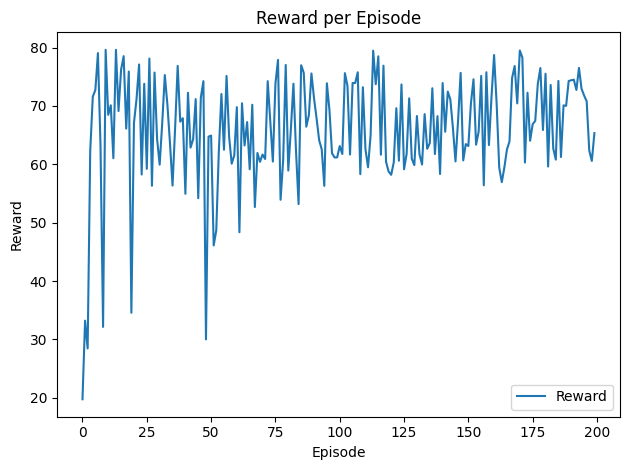

In [202]:
for i in range(1, episodes+1):
    if episodes - i < 4:
        env = gym.make('MountainCar-v0', render_mode='human')
    state, _ = env.reset()
    episode_len = 0
    score = 0
    position_score = 0
    velocity_score = 0

    while True:
        state = torch.FloatTensor([state])
        action = agent.action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        reward, position_reward, velocity_reward = calc_reward(state)

        if terminated:
            reward += 100
        
        agent.memorize(state, action, reward, next_state)
        agent.learning()

        state = next_state
        episode_len += 1
        score += reward

        position_score += position_reward
        velocity_score += velocity_reward

        eps = e_end + (e_start - e_end)*np.exp(-(e_step/e_decay))
        e_step += 1

        if terminated or truncated:
            print(f"Episode: {i} / episode_len: {episode_len} / pos : {position_score:.2f} / vel : {velocity_score:.2f} / eps : {eps:.3f}")
            scores.append(score)

            # reward graph
            plt.clf()
            plt.plot(scores, label="Reward")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.title("Reward per Episode")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"MountainCar_DQN_reward.png")

            break

env.close()

In [13]:
env.close()

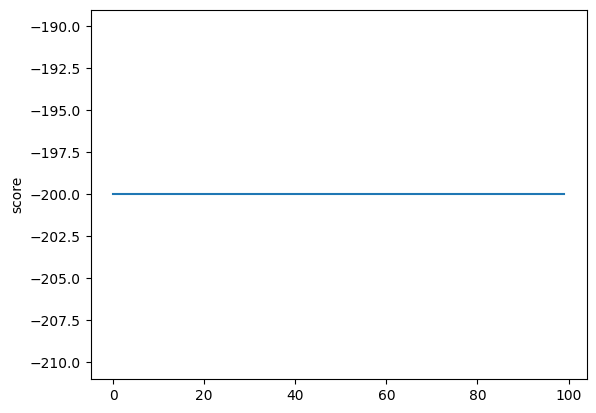

In [14]:
plt.plot(scores)
plt.ylabel('score')
plt.show()